In [41]:
import json, pickle
import numpy as np
from keras.models import Model
from keras.layers import Input, Embedding, Bidirectional, LSTM, TimeDistributed, Dense
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from seqeval.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import CategoricalAccuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt


In [42]:

data = []

with open("../dataset/dataset_ner_srl.tsv", encoding="utf-8") as f:
    tokens, ner_labels, srl_labels = [], [], []
    
    for line in f:
        line = line.strip()
        if not line:
            if tokens:
                data.append({
                    "tokens": tokens,
                    "labels_ner": ner_labels,
                    "labels_srl": srl_labels
                })
                tokens, ner_labels, srl_labels = [], [], []
        else:
            token, ner, srl = line.split("\t")
            tokens.append(token)
            ner_labels.append(ner)
            srl_labels.append(srl)

# Preprocessing sama seperti sebelumnya
sentences = [[tok.lower() for tok in item["tokens"]] for item in data]
labels_ner = [item["labels_ner"] for item in data]
labels_srl = [item["labels_srl"] for item in data]

total_kalimat = len(data)
total_token = sum(len(item["tokens"]) for item in data)

print("Total kalimat:", total_kalimat)
print("Total token:", total_token)

Total kalimat: 159
Total token: 1891


In [43]:
# tagging 
words = sorted({w for s in sentences for w in s})
ner_tags = sorted({t for seq in labels_ner for t in seq})
srl_tags = sorted({t for seq in labels_srl for t in seq})

word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["PAD"], word2idx["UNK"] = 0, 1

tag2idx_ner = {t: i for i, t in enumerate(ner_tags)}
tag2idx_srl = {t: i for i, t in enumerate(srl_tags)}
idx2tag_ner = {i: t for t, i in tag2idx_ner.items()}
idx2tag_srl = {i: t for t, i in tag2idx_srl.items()}

In [44]:
# encoding

X = [[word2idx.get(w, word2idx["UNK"]) for w in s] for s in sentences]
y_ner = [[tag2idx_ner[t] for t in seq] for seq in labels_ner]
y_srl = [[tag2idx_srl[t] for t in seq] for seq in labels_srl]

maxlen = 50 

X = pad_sequences(X, maxlen=maxlen, padding="post", value=word2idx["PAD"])
y_ner = pad_sequences(y_ner, maxlen=maxlen, padding="post", value=tag2idx_ner["O"])
y_srl = pad_sequences(y_srl, maxlen=maxlen, padding="post", value=tag2idx_srl["O"])

y_ner = [to_categorical(seq, num_classes=len(tag2idx_ner)) for seq in y_ner]
y_srl = [to_categorical(seq, num_classes=len(tag2idx_srl)) for seq in y_srl]

X = np.array(X)
y_ner = np.array(y_ner)
y_srl = np.array(y_srl)

In [45]:
X_train, X_test, y_ner_train, y_ner_test, y_srl_train, y_srl_test = train_test_split(
    X, y_ner, y_srl,            
    test_size=0.20,             
    random_state=42,
    shuffle=True            
)

In [46]:
input_layer = Input(shape=(maxlen,))
embed = Embedding(len(word2idx), 64)(input_layer)
bilstm = Bidirectional(LSTM(64, return_sequences=True))(embed)

ner_output = TimeDistributed(
    Dense(len(tag2idx_ner), activation="softmax"), name="ner_output"
)(bilstm)
srl_output = TimeDistributed(
    Dense(len(tag2idx_srl), activation="softmax"), name="srl_output"
)(bilstm)

model = Model(inputs=input_layer, outputs=[ner_output, srl_output])
model.compile(
    optimizer="adam",
    loss={
        "ner_output": "categorical_crossentropy",
        "srl_output": "categorical_crossentropy",
    },
    metrics={
        "ner_output": [CategoricalAccuracy(name="accuracy")],
        "srl_output": [CategoricalAccuracy(name="accuracy")],
    },
)

model.summary()
model.fit(
    X_train, {"ner_output": y_ner_train, "srl_output": y_srl_train}, 
    validation_data=(X_test, {"ner_output": y_ner_test, "srl_output": y_srl_test}),
    batch_size=2,
    epochs=10,
    verbose=1
)

# ---------- 6. Simpan artefak ----------
model.save("multi_task_lstm_ner_srl_model.keras")
with open("word2idx.pkl", "wb") as f:
    pickle.dump(word2idx, f)
with open("tag2idx_ner.pkl", "wb") as f:
    pickle.dump(tag2idx_ner, f)
with open("tag2idx_srl.pkl", "wb") as f:
    pickle.dump(tag2idx_srl, f)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 50)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, 50, 64)    │     46,016 │ input_layer_4[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_4     │ (None, 50, 128)   │     66,048 │ embedding_4[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ner_output          │ (None, 50, 25)    │      3,225 │ bidirectional_4[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ srl_output          │ (None, 50, 18)    │      2,322 │ bidirectional_4[… │
│ (TimeDistributed)   │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 117,611 (459.42 KB)

 Trainable params: 117,611 (459.42 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - loss: 3.2183 - ner_output_accuracy: 0.8700 - ner_output_loss: 1.5503 - srl_output_accuracy: 0.7278 - srl_output_loss: 1.6679 - val_loss: 0.7435 - val_ner_output_accuracy: 0.9488 - val_ner_output_loss: 0.2671 - val_srl_output_accuracy: 0.8413 - val_srl_output_loss: 0.4764
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7484 - ner_output_accuracy: 0.9476 - ner_output_loss: 0.2574 - srl_output_accuracy: 0.8292 - srl_output_loss: 0.4911 - val_loss: 0.6928 - val_ner_output_accuracy: 0.9488 - val_ner_output_loss: 0.2566 - val_srl_output_accuracy: 0.8538 - val_srl_output_loss: 0.4362
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7115 - ner_output_accuracy: 0.9501 - ner_output_loss: 0.2363 - srl_output_accuracy: 0.8392 - srl_output_loss: 0.4751 - val_loss: 0.6501 - val_ner_output_accuracy: 0.9488 - val_ner_output_loss: 0.2476 - val_srl_output_accuracy: 0.8556 - val_srl_output_loss: 0.4026
Epoch 4/10
64/64 ━━━━━━━━

In [47]:
# evaluation

print("Metrics names:", model.metrics_names)


results = model.evaluate(
    X_test,
    {"ner_output": y_ner_test, "srl_output": y_srl_test},
    verbose=0
)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value}")
    
def token_level_accuracy(y_true, y_pred):
    total, correct = 0, 0
    for true_seq, pred_seq in zip(y_true, y_pred):
        for t, p in zip(true_seq, pred_seq):
            if t.sum() == 0:  # skip PAD
                continue
            total += 1
            if t.argmax() == p.argmax():
                correct += 1
    return correct / total


def decode(pred, true, idx2tag):
    out_true, out_pred = [], []
    for p_seq, t_seq in zip(pred, true):
        t_labels, p_labels = [], []
        for p_tok, t_tok in zip(p_seq, t_seq):
            if t_tok.sum() == 0:          # token PAD → lewati
                continue
            t_labels.append(idx2tag[t_tok.argmax()])
            p_labels.append(idx2tag[p_tok.argmax()])
        out_true.append(t_labels)
        out_pred.append(p_labels)
    return out_true, out_pred

# prediksi hanya pada test set
y_pred_ner, y_pred_srl = model.predict(X_test, verbose=0)

true_ner, pred_ner = decode(y_pred_ner, y_ner_test, idx2tag_ner)

acc_ner = token_level_accuracy(y_ner_test, y_pred_ner)
acc_srl = token_level_accuracy(y_srl_test, y_pred_srl)

print(f"[NER] Token-level Accuracy: {acc_ner:.1f}")
print(f"[SRL] Token-level Accuracy: {acc_srl:.1f}")
# print(idx2tag_ner)
print("[NER] Classification Report (test set):")
print(classification_report(true_ner, pred_ner, digits=2))


Metrics names: ['loss', 'compile_metrics', 'ner_output_loss', 'srl_output_loss']
loss: 0.47491562366485596
compile_metrics: 0.18545177578926086
ner_output_loss: 0.2894638478755951
srl_output_loss: 0.9550000429153442
[NER] Token-level Accuracy: 1.0
[SRL] Token-level Accuracy: 0.9
[NER] Classification Report (test set):
              precision    recall  f1-score   support

        DATE       0.33      0.09      0.14        11
       EVENT       0.00      0.00      0.00         1
         LOC       1.00      0.19      0.32        21
         MIN       0.00      0.00      0.00         3
        MISC       0.00      0.00      0.00         1
         ORG       0.00      0.00      0.00         3
         PER       0.00      0.00      0.00         2
         RES       0.00      0.00      0.00         2
        TIME       0.00      0.00      0.00         8

   micro avg       0.42      0.10      0.16        52
   macro avg       0.15      0.03      0.05        52
weighted avg       0.47      0

In [48]:
true_srl, pred_srl = decode(y_pred_srl, y_srl_test, idx2tag_srl)
# print(idx2tag_srl)
print("[SRL] Classification Report (test set):")
print(classification_report(true_srl, pred_srl, digits=2))

[SRL] Classification Report (test set):
              precision    recall  f1-score   support

         FRQ       0.00      0.00      0.00         1
         LOC       0.21      0.43      0.29         7
         MNR       0.00      0.00      0.00         3
         PRP       0.00      0.00      0.00         1
         RG0       0.20      0.24      0.22        17
         RG1       0.20      0.19      0.19        47
         RG2       0.25      0.45      0.32        11
         RG3       0.00      0.00      0.00         3
         TMP       0.59      0.72      0.65        18
           _       0.50      0.12      0.20        33

   micro avg       0.29      0.27      0.28       141
   macro avg       0.20      0.22      0.19       141
weighted avg       0.31      0.27      0.26       141



/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG1 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARG0 seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: V seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: ARGM-TMP seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/mnt/disc1/code/thesis_quiz_project/lstm-quiz/myenv/lib64/python3.10/site-packages/seqeval/

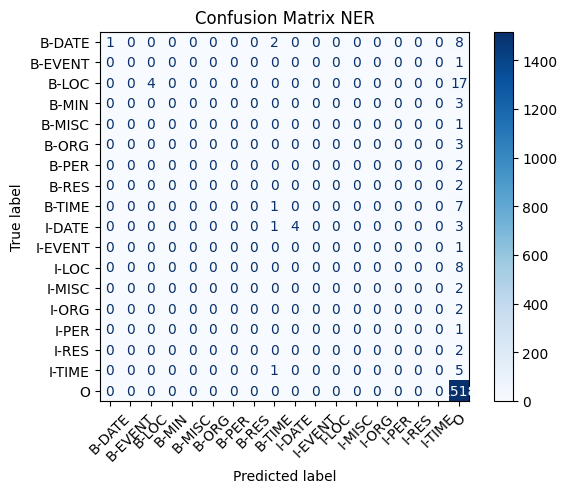

In [49]:
flat_true_ner = [t for seq in true_ner for t in seq]
flat_pred_ner = [p for seq in pred_ner for p in seq]

labels_ner = sorted(list(set(flat_true_ner + flat_pred_ner)))
cm_ner = confusion_matrix(flat_true_ner, flat_pred_ner, labels=labels_ner)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_ner, display_labels=labels_ner)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix NER")
plt.show()

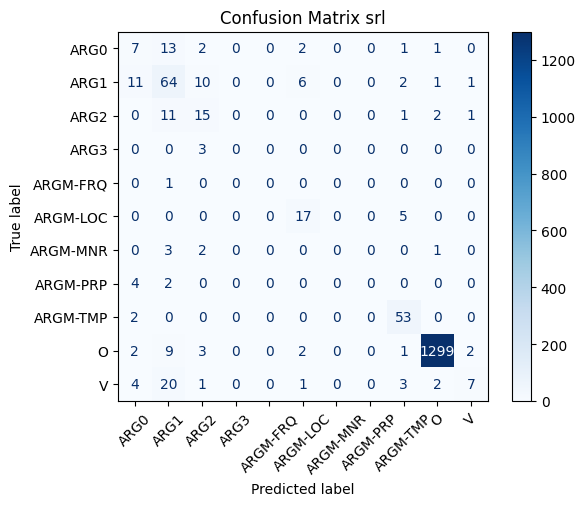

In [50]:
flat_true_srl = [t for seq in true_srl for t in seq]
flat_pred_srl = [p for seq in pred_srl for p in seq]

labels_srl = sorted(list(set(flat_true_srl + flat_pred_srl)))
cm_srl = confusion_matrix(flat_true_srl, flat_pred_srl, labels=labels_srl)

disp = ConfusionMatrixDisplay(confusion_matrix=cm_srl, display_labels=labels_srl)
disp.plot(xticks_rotation=45, cmap=plt.cm.Blues)
plt.title("Confusion Matrix srl")
plt.show()